In [1]:
import pandas as pd
import re
import bz2
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from scipy.spatial.distance import cosine
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.cluster import FeatureAgglomeration
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import euclidean, cityblock

In [2]:
bills = df_cleaned = pd.read_pickle('../data_cleaning/clean_data.pkl')

In [3]:
bills['combined_title']

0        special measure lower cost medicine act prescr...
1        constitutional convention act act calling cons...
2        magna carta patient right obligation act decla...
3        health promotion act 2004 act establishing nat...
4        increasing allowable personal additional tax e...
                               ...                        
15635    converting arakancalinan municipal road munici...
15636    university abra act converting abra state inst...
15637    cagayan valley medical center – abulug extensi...
15638    bineng national high school act converting ben...
15639    converting monggayang municipality aguinaldo p...
Name: combined_title, Length: 15640, dtype: object

### Vectorization and IDF scaling

In [6]:
tfidf = TfidfVectorizer(token_pattern=r'[a-z]+', stop_words='english', min_df=0.01, max_df=0.99).fit(bills['combined_title'])
X_idf  = tfidf.transform(bills['combined_title']).toarray()
X_feat_names = tfidf.get_feature_names()

In [7]:
X_idf.shape

(15640, 210)

In [8]:
def truncated_svd(X):
    '''Reduce dimensionality of TFIDF Matrix.'''
    q, s, p = np.linalg.svd(X)
    return q, np.diag(s), p.T, s**2/np.linalg.norm(s**2, 1)

q, s, p, nssd = truncated_svd(X_idf)

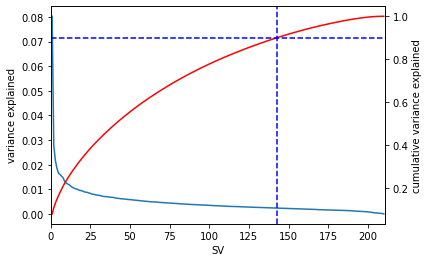

In [11]:
fig, ax = plt.subplots()

ax.plot(range(1, len(nssd)+1), nssd, '-', label='individual')
ax.set_xlim(0, len(nssd)+1)
ax.set_xlabel('SV')
ax.set_ylabel('variance explained')
ax = ax.twinx()
ax.plot(range(1, len(nssd)+1), nssd.cumsum(), 'r-', label='cumulative')
ax.axhline(0.9, ls='--', color='b')
ax.axvline(143, ls='--', color='b')
ax.set_ylabel('cumulative variance explained');

In [12]:
X_trunc = X_idf.dot(p[:, :143])

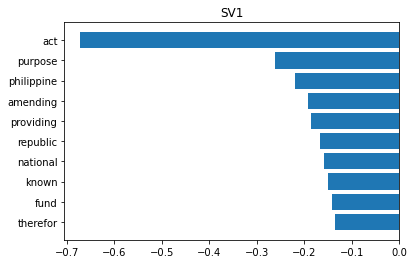

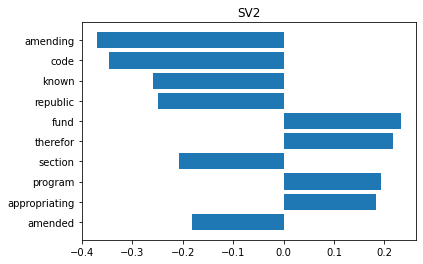

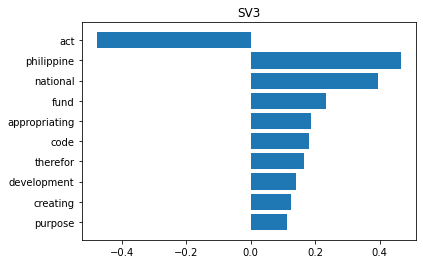

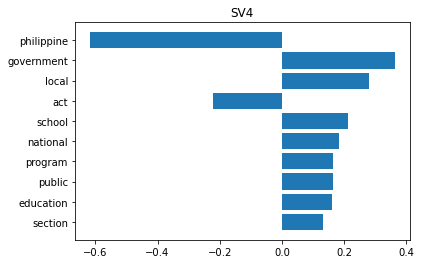

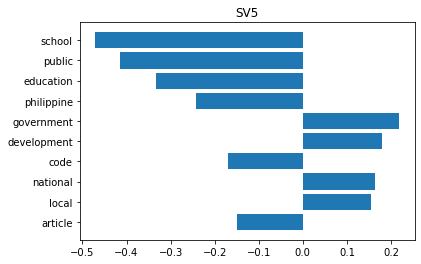

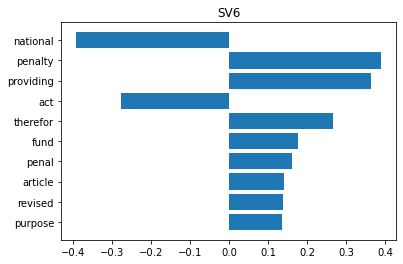

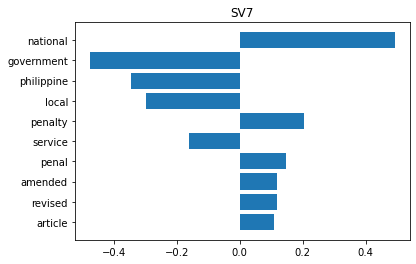

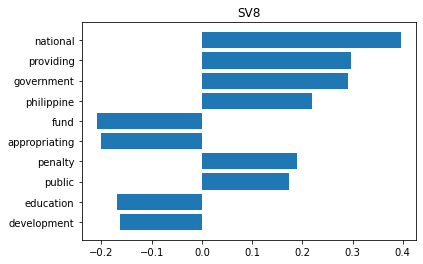

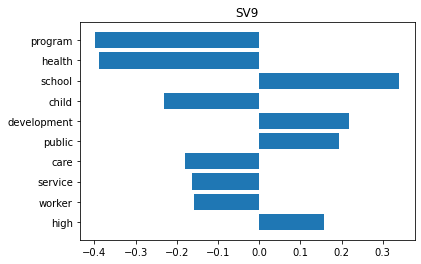

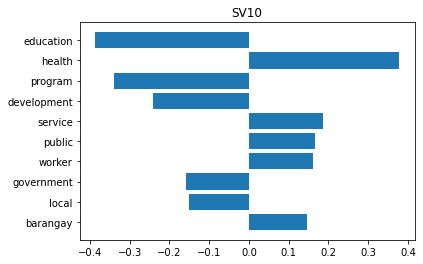

In [13]:
for i in range(10):
    fig, ax = plt.subplots()
    order = np.argsort(np.abs(p[:, i]))[-10:]
    ax.barh([X_feat_names[o] for o in order], p[order, i])
    ax.set_title(f'SV{i+1}')

In [14]:
def pooled_within_ssd(X, y, centroids, dist):
    """Compute pooled within-cluster sum of squares around the cluster mean
    
    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Number of pairs to sample
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point
        
    Returns
    -------
    float
        Pooled within-cluster sum of squares around the cluster mean
    """
    Q_j = np.zeros(len(np.unique(y)))
    for index, cluster_i in enumerate(y):
        Qj_col = {v: k for k, v in enumerate(np.unique(y))}
        Q_j[Qj_col[cluster_i]] += dist(X[index, :], centroids[cluster_i, :])**2
    return sum(0.5*Q_j/np.unique(y, return_counts=True)[1])

def gap_statistic(X, y, centroids, dist, b, clusterer, random_state=None):
    """Compute the gap statistic
    
    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Number of pairs to sample
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point
    b : int
        Number of realizations for the reference distribution
    clusterer : KMeans
        Clusterer object that will be used for clustering the reference 
        realizations
    random_state : int, default=None
        Determines random number generation for realizations
        
    Returns
    -------
    gs : float
        Gap statistic
    gs_std : float
        Standard deviation of gap statistic
    """
    rng = np.random.default_rng(random_state)
    W_ki = []
    for i in range(b):
        distribution = rng.uniform(X.min(0), X.max(0), X.shape)
        realizations = clusterer.fit_predict(distribution)
        W_ki.append(np.log(pooled_within_ssd(distribution, realizations, 
                                             clusterer.cluster_centers_, 
                                             dist)))
    E_logWk = np.mean(W_ki)
    Gap = E_logWk - np.log(pooled_within_ssd(X, y, centroids, dist))
    return Gap, np.std(W_ki)

inertia = []
CH = []
SC= []
GS = []
y_pred_list = []

for k in range(2, 6):
    km = KMeans(n_clusters=k, max_iter=300, tol=1e-4, n_jobs=-1).fit(X_trunc)
    y_pred = km.predict(X_trunc)
    y_pred_list.append(y_pred)
    inertia.append(km.inertia_)
    CH.append(calinski_harabasz_score(X_trunc, y_pred))
    SC.append(silhouette_score(X_trunc, y_pred))
    GS.append(gap_statistic(X_trunc, y_pred, km.cluster_centers_, euclidean,
                            len(np.unique(y_pred)), KMeans(n_clusters=k),
                            random_state=42)[0])

In [15]:
## Plot the clusters

X_trunc2 = (TruncatedSVD(n_components=2)
                    .fit_transform(X_idf))

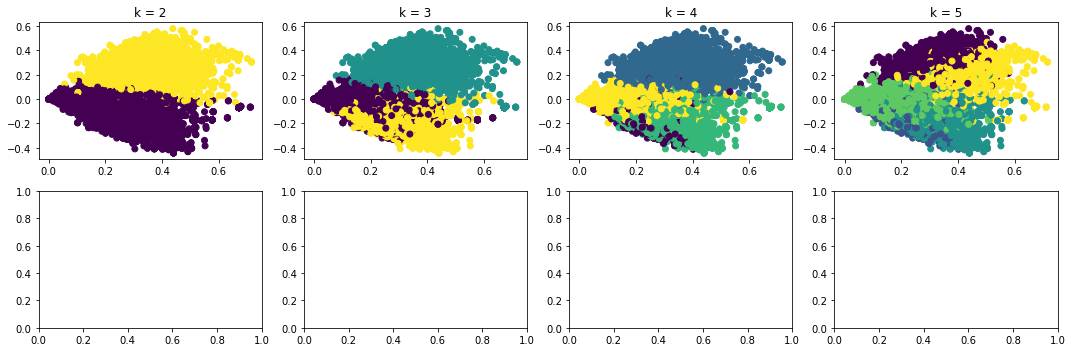

In [16]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(15, 5))
ax_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

for i in range(2, 6):
    ax_list[i-2].scatter(X_trunc2[:, 0], X_trunc2[:, 1], c=y_pred_list[i-2])
    ax_list[i-2].set_title(f'k = {i}')
    
plt.tight_layout()

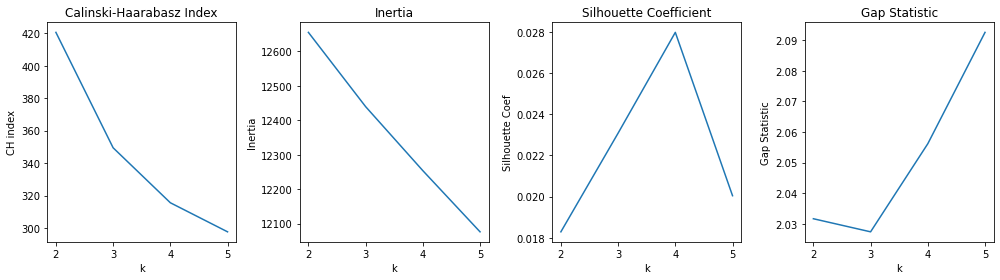

In [17]:
## check the trend of scores

scores_df = pd.DataFrame([inertia, CH, SC, GS]).T
scores_df.columns = ['inertia', 'CH', 'SC', 'GS']
scores_df.index = range(2,6)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(14,4))
scores_df['CH'].plot(kind='line', ax=ax1)
scores_df['inertia'].plot(kind='line', ax=ax2)
scores_df['SC'].plot(kind='line', ax=ax3)
scores_df['GS'].plot(kind='line', ax=ax4)

ax1.set_title('Calinski-Haarabasz Index')
ax1.set_ylabel('CH index')
ax1.set_xlabel('k')
ax2.set_title('Inertia')
ax2.set_ylabel('Inertia')
ax2.set_xlabel('k')
ax3.set_title('Silhouette Coefficient')
ax3.set_ylabel('Silhouette Coef')
ax3.set_xlabel('k')
ax4.set_title('Gap Statistic')
ax4.set_ylabel('Gap Statistic')
ax4.set_xlabel('k')

plt.tight_layout()

In [18]:
## try k=3

km = KMeans(n_clusters=3, max_iter=300, tol=1e-4, n_jobs=-1).fit(X_trunc)
y_pred = km.predict(X_trunc)

### Information Retrieval

In [19]:
def nearest_k(query, objects, k, dist):
    """Return the indices to objects most similar to query
    
    Parameters
    ----------
    query : ndarray
        query object represented in the same form vector representation as the
        objects
    objects : ndarray
        vector-represented objects in the database; rows correspond to 
        objects, columns correspond to features
    k : int
        number of most similar objects to return
    dist : function
        accepts two ndarrays as parameters then returns their distance
    
    Returns
    -------
    ndarray
        Indices to the most similar objects in the database
    """
    return np.argsort([dist(query, o) for o in objects])[:k]

In [20]:
class Vectorizer:
    def __init__(self):
        self.index_word = {}
        self.word_index = {}
        
    def build_mappings(self, docs):
        """Initialize word-index mappings
        
        Parameter
        ---------
        docs : sequence of str
            Corpus to build mappings for
        """
        words = set(" ".join([doc.lower().strip() for doc in docs]).split())
        words = sorted(words)
        self.index_word = dict(enumerate(words))
        self.word_index = dict(zip(self.index_word.values(), self.index_word.keys()))

    def vectorize(self, doc):
        """Return the BoW vector representation of doc
        
        Parameters
        ----------
        doc : str
            Text to compute the vector representation of
            
        Returns
        -------
        vec : ndarray
            BoW vector representation of doc
        """
        bow = np.zeros(len(self.word_index))
        word_count = Counter(doc.lower().split())
        for word, cnt in word_count.most_common():
            if word in self.word_index:
                bow[self.word_index[word]] = cnt
        return bow

In [21]:
def pr_curve(query, objects, dist, actual, all_labels):
    all_labels = np.array(all_labels)
    results = nearest_k(query, objects, len(all_labels), dist)
    rs = (all_labels[results] == actual).cumsum()
    N = (all_labels == actual).sum()
    precision = rs / np.arange(1, len(rs)+1)
    recalls = rs / N
#     print(rs)
#     print(N)
#     print(recalls)
    recalls = [0] + recalls.tolist()
    precision = [1] + precision.tolist()
#     print(recalls)
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.step(recalls, precision, where='post')
    ax.fill_between(recalls, precision, step='post', alpha=0.6)
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    
    return ax

In [22]:
def auc_pr(query, objects, dist, actual, all_labels):
    ax = pr_curve(query, objects, dist, actual, all_labels)
    
    x = ax.lines[0].get_data()[0]
    y = ax.lines[0].get_data()[1]
    
    return np.trapz(y, x)

0.5247226750320961

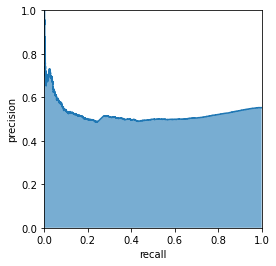

In [23]:
auc_pr(X_trunc[0, :], X_trunc, euclidean, y_pred[0], y_pred)

In [81]:
nearest_k(X_trunc[0, :], X_trunc, 10, euclidean)

array([    0,  3321,   757,  9883,  7159, 11189,  6141, 10130, 12858,
        7465])

In [137]:
from collections import Counter

# tf = CountVectorizer(token_pattern=r'[a-z]+').fit(bills['long_title'])
# X_tf  = tf.transform(bills['long_title']).toarray()
# X_tf_names = tf.get_feature_names()

# vectorizer = Vectorizer()
# vectorizer.build_mappings(bills['long_title'])
# vec = vectorizer.vectorize(data_newsgroups['data'][0])



# bills.iloc[nearest_k(tfidf.transform(np.array(['query'])), X_idf, 5, euclidean)]
X_idf[0, :].sum(axis=0)
# bills['long_title'].loc[0]

1.643603439650886

In [150]:
query = ['AN ACT PRESCRIBING SPECIAL  MEASURES  TO LOWER THE COST OF     MEDICINES AND FOR OTHER PURPOSES']
tfidf.transform(query).toarray()[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     